In [1]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# pd.options.display.max_columns = None # Display all columns in pandas DataFrame

# Load data and drop columns with sensitive information
order_history = pd.read_csv(r'Amazon-order-history-20220818\Retail.OrderHistory.1.csv')
order_history.drop(['Shipping Address', 'Billing Address', 'Payment Instrument Type'], axis= 1, inplace=True)
order_history.head()

,Website,Order ID,Order Date,Purchase Order Number,Currency,Unit Price,Unit Price Tax,Shipping Charge,Total Discounts,Total Owed,...,Quantity,Order Status,Shipment Status,Ship Date,Shipping Option,Carrier Name & Tracking Number,Product Name,Gift Message,Gift Sender Name,Gift Recipient Contact Details
0,Amazon.ca,701-8892299-1469041,08/11/2022 20:08:06 UTC,NaN,CAD,27.99,1.40,0.0,0,29.39,...,1,Closed,Shipped,08/12/2022 01:13:10 UTC,next-ca,AMZN_CA(TBC488531362009),"Webber Naturals Coenzyme Q10 (CoQ10) 200mg, 60...",NaN,NaN,NaN
1,Amazon.ca,701-5721624-9305845,07/15/2022 17:48:57 UTC,NaN,CAD,12.99,1.56,0.0,0,14.55,...,1,Closed,Shipped,07/16/2022 10:53:00 UTC,next-ca,AMZN_CA(TBC470824687009),"M&B SnowGuard Boot Protector, 300g/10.5oz, Pro...",NaN,NaN,NaN
2,Amazon.ca,701-0769026-4317861,07/15/2022 17:48:57 UTC,NaN,CAD,8.99,1.08,0.0,0,10.07,...,1,Closed,Shipped,07/15/2022 21:42:41 UTC,same-ca,AMZN_CA(TBC470684239009),"Moneysworth & Best Shoe Care Leather Cleaner, ...",NaN,NaN,NaN
3,Amazon.ca,701-0769026-4317861,07/15/2022 17:48:57 UTC,NaN,CAD,21.99,2.64,0.0,0,24.63,...,1,Closed,Shipped,07/15/2022 21:42:41 UTC,same-ca,AMZN_CA(TBC470684239009),5 Pack Labelife TZe-231 P Touch Label Maker Ta...,NaN,NaN,NaN
4,Amazon.ca,702-3541202-8686608,07/14/2022 05:04:12 UTC,NaN,CAD,9.99,1.20,0.0,0,11.19,...,1,Closed,Shipped,07/16/2022 01:13:33 UTC,second-ca,AMZN_CA(TBC470516473009),[4 Pack] MAYtobe For Huawei P20 Screen Protect...,NaN,NaN,NaN


# Data Cleaning

In [2]:
# Rename columns
order_history.columns = order_history.columns.str.lower().str.replace(' ', '_')

# Select columns to work with
order_history = order_history[['website', 'product_name', 'order_id', 'order_date', 'unit_price',
                               'unit_price_tax', 'shipping_charge', 'total_discounts',
                               'total_owed']]

# Convert numeric columns from string to numeric data type
numeric_cols = order_history.iloc[:,4:]
numeric_cols.replace(',','', regex=True, inplace=True)
numeric_cols = list(numeric_cols.columns)
order_history[numeric_cols] = order_history[numeric_cols].apply(pd.to_numeric, errors='coerce', axis=1)

# Convert "order_date" column to datetime type 
order_history['order_date'] = order_history.order_date.str.replace('UTC','').str.strip()
order_history['order_date'] = pd.to_datetime(order_history.order_date, format='%m/%d/%Y %X')

# Filter purchases made after 2018 and in Amazon Canada
order_history = order_history[order_history.website == 'Amazon.ca']
order_history = order_history[(order_history.order_date > '2019-01-01')]

# Group data and perfom sum aggregation
order_history = order_history.groupby(['website','order_id', 'order_date']).agg(unit_price = ('unit_price','sum'),
                                                                         unit_price_tax = ('unit_price_tax', 'sum'),
                                                                         shipping_charge = ('shipping_charge', 'sum'),
                                                                         total_discounts = ('total_discounts', 'sum'),
                                                                         total_owed = ('total_owed', 'sum')).reset_index()

# Split order_date into year, month name and day columns
order_history['year'] = order_history['order_date'].dt.year
order_history['month'] = order_history['order_date'].dt.month_name()
order_history['day'] = order_history['order_date'].dt.day

# Sort data by year
order_history.sort_values(by=['year'], ascending=False, inplace=True)

# Data Analysis

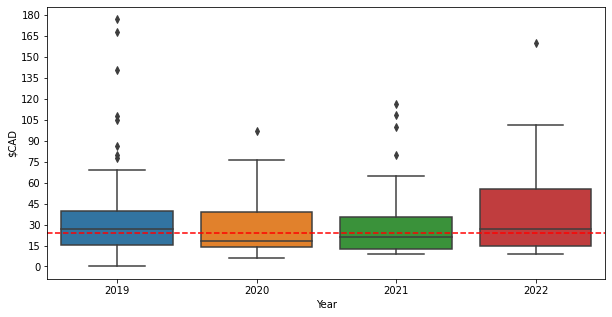

In [3]:
fig = plt.figure(figsize = (10,5))
ax = sns.boxplot(x='year', y='unit_price', data=order_history)
ax.set_yticks(np.arange(0, max(order_history.unit_price)+15, 15))
ax.set_xlabel('Year', fontsize = 10)
ax.set_ylabel('$CAD', fontsize = 10)
ax.axhline(24, ls='--', color='red')
plt.show()
fig.savefig('boxplot-orders-2022.png', facecolor='white')

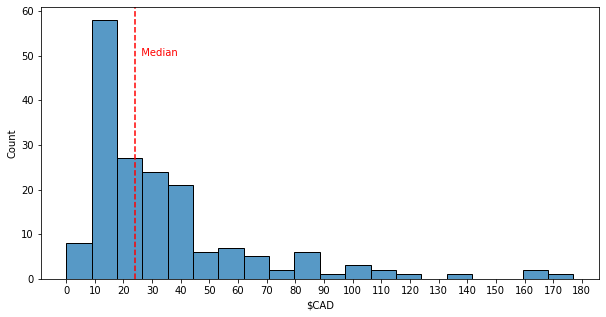

In [4]:
fig = plt.figure(figsize = (10,5))
ax = sns.histplot(x='unit_price', data=order_history)
ax.set_xticks(np.arange(0, max(order_history.unit_price)+5, 10))
ax.set_xlabel('$CAD', fontsize = 10)
ax.set_ylabel('Count', fontsize = 10)
ax.axvline(24, ls='--', color='red')
ax.text(x=24, y=50, s='  Median', color='red')
plt.show()
fig.savefig('histogram-orders-2022.png', facecolor='white')

In [5]:
# Calculate desciptive statistics
describe = pd.DataFrame(order_history.unit_price.describe())
describe.loc['median'] = order_history.unit_price.median()
describe.drop(['count', 'min'], inplace=True)
describe = describe.reindex(['mean', 'median', 
                             'std', 'max', 
                             '25%','50%','75%'])
describe = describe.round(2)
describe

,unit_price
mean,34.13
median,23.99
std,30.91
max,177.09
25%,14.19
50%,23.99
75%,39.76


- Given that the data doesn't have a normal distribution, and because the standard deviation is close to the mean, the median rather than the mean is a better measure of describing the "average" amount per amazon order. Therefore, most amazon orders are below \\$24 CAD, which is still lower than the minimum amount of \\$25 to obtain free shipping if you are not a prime member in Canada. So close though!

## Modeling Shipping Costs without Amazon Prime

- Shipping rates depend on the shipping speed, the weight and the size of the items. For example, prime customers pay a flat rate of \\$6.99 for orders under \\$25, while non-prime members pay more than \\$11.99 for same-day shipping. 
- On the other hand, shipping rates for items sold by third party sellers and fulfilled by Amazon from outside Canada cost \\$4.99 + \\$3.28/kg and it takes 7-12 business days to arrive.
- As a conservative measure, shipping rates are estimated as \\$7.99 per shipment.

In [21]:
# Orders with unit_price < 25 are assigned a shipping cost of $7.99 in a new shipping column
order_history['shipping'] = order_history['unit_price'].apply(lambda x: 7.99 if x < 25 else 0.0)

model = order_history.groupby('year')['shipping'].sum()
model = pd.DataFrame(model)
model['End up Saving ($CAD)'] = model.shipping - 99
model.rename(columns={'shipping':'Shipping without Prime ($CAD)'}, inplace=True)
model.index.names = ['Year']
model.style.format({'Shipping without Prime ($CAD)': '{:.2f}','End up Saving ($CAD)': '{:+g}'})

,Shipping without Prime ($CAD),End up Saving ($CAD)
Year,,
2019,263.67,+164.67
2020,127.84,+28.84
2021,207.74,+108.74
2022,103.87,+4.87


# Conclusion

 - Although Amazon prime provides various benefits such as Prime Video, Prime Music, free shipping and exclusive deals, the only benefits I use are free shipping and exlusive deals. Based on my Amazon order history, prime provides value to me by lowering the total shipping costs I would have paid in a year, plus getting faster shipping. For example, in 2021 I would have paid \\$108.74 more on shipping costs if I was not a prime member. Therefore, next year I will renew my prime membership even if its price increased 20%. And I will continue to evaluate my decision on a yearly basis.
